In [49]:
import numpy as np
from numpy.matlib import repmat
import matplotlib.pyplot as plt
from PIL import Image, ImageFilter, ImageChops
import cv2
from skimage import filters, measure
from skimage.measure import label, regionprops
from skimage.color import label2rgb
from sklearn.cluster import KMeans
import matplotlib.patches as mpatches
from scipy.signal import convolve2d
from scipy.spatial import KDTree
import seaborn as sns, pickle, librosa as lb, time, cProfile, os, os.path, pyximport
pyximport.install()
import multiprocessing
imagefile = 'data/queries/p1_q1.jpg'
midi_db_dir = 'experiments/train/db'
thumbnailW = 100
thumbnailH = 100
thumbnailFilterSize = 5
estLineSep_NumCols = 3
estLineSep_LowerRange = 13
estLineSep_UpperRange = 27
estLineSep_Delta = 1
targetLineSep = 10.0
morphFilterHorizLineSize = 41
notebarFiltLen = 3
notebarRemoval = 0.9
calcStaveFeatureMap_NumCols = 10
calcStaveFeatureMap_LowerRange = 8.5
calcStaveFeatureMap_UpperRange = 11.75
calcStaveFeatureMap_Delta = 0.25
morphFilterCircleSizeReduce = 5
morphFilterCircleSizeExpand = 5
notedetect_minarea = 50
notedetect_maxarea = 200
noteTemplateSize = 21
notedetect_tol_ratio = 0.4
chordBlock_minH = 1.25
chordBlock_maxH = 4.25
chordBlock_minW = 0.8
chordBlock_maxW = 2.25
chordBlock_minArea = 1.8
chordBlock_maxArea = 4.5
chordBlock_minNotes = 2
chordBlock_maxNotes = 4
maxDeltaRowInitial = 50
minNumStaves = 8
maxNumStaves = 16
minStaveSeparation = 6 * targetLineSep
maxDeltaRowRefined = 15
morphFilterVertLineLength = 101
morphFilterVertLineWidth = 7
maxBarlineWidth = 15
bootlegRepeatNotes = 2
bootlegFiller = 1
dtw_steps = [
 1, 1, 1, 2, 2, 1]
dtw_weights = [1, 1, 2]

def removeBkgdLighting(pimg, filtsz=5, thumbnailW=100, thumbnailH=100):
    tinyimg = pimg.copy()
    tinyimg.thumbnail([thumbnailW, thumbnailH])
    shadows = tinyimg.filter(ImageFilter.GaussianBlur(filtsz)).resize(pimg.size)
    result = ImageChops.invert(ImageChops.subtract(shadows, pimg))
    return result


def getPenalizedCombFilter(linesep):
    filt = np.zeros(int(np.round(linesep * 5)))
    for i in range(5):
        offset = int(np.round(0.5 * linesep + i * linesep))
        filt[offset - 1:offset + 2] = 1.0

    for i in range(6):
        center = int(np.round(i * linesep))
        startIdx = max(center - 1, 0)
        endIdx = min(center + 2, len(filt))
        filt[startIdx:endIdx] = -1.0

    return filt


def estimateLineSep(pim, ncols, lrange, urange, delta):
    img = 255 - np.array(pim)
    imgHeight, imgWidth = img.shape
    rowMedians = np.zeros((imgHeight, ncols))
    colWidth = imgWidth // (ncols + 2)
    for i in range(ncols):
        rowMedians[:, i] = np.median((img[:, (i + 1) * colWidth:(i + 2) * colWidth]), axis=1)

    lineseps = np.arange(lrange, urange, delta)
    responses = np.zeros((len(lineseps), imgHeight, ncols))
    for i, linesep in enumerate(lineseps):
        filt = getPenalizedCombFilter(linesep).reshape((-1, 1))
        responses[i, :, :] = convolve2d(rowMedians, filt, mode='same')

    scores = np.sum(np.max(responses, axis=1), axis=1)
    bestIdx = np.argmax(scores)
    estLineSep = lineseps[bestIdx]
    return (
     estLineSep, scores)


def calcResizedDimensions(pim, estimatedLineSep, desiredLineSep):
    curH, curW = pim.height, pim.width
    scale_factor = 1.0 * desiredLineSep / estimatedLineSep
    targetH = int(curH * scale_factor)
    targetW = int(curW * scale_factor)
    return (
     targetH, targetW)


def getNormImage(img):
    X = 1 - np.array(img) / 255.0
    return X


def showGrayscaleImage(X, sz=(10, 10), maxval=1, inverted=True):
    plt.figure(figsize=sz)
    if inverted:
        plt.imshow((maxval - X), cmap='gray')
    else:
        plt.imshow(X, cmap='gray')


def morphFilterRectangle(arr, kernel_height, kernel_width):
    kernel = np.ones((kernel_height, kernel_width), np.uint8)
    result = cv2.erode(arr, kernel, iterations=1)
    result = cv2.dilate(result, kernel, iterations=1)
    return result


def isolateStaffLines(arr, kernel_len, notebarfilt_len, notebar_removal):
    lines = morphFilterRectangle(arr, 1, kernel_len)
    notebarsOnly = morphFilterRectangle(lines, notebarfilt_len, 1)
    result = np.clip(lines - notebar_removal * notebarsOnly, 0, None)
    return result


def getCombFilter(lineSep):
    stavelen = int(np.ceil(4 * lineSep)) + 1
    combfilt = np.zeros(stavelen)
    for i in range(5):
        idx = i * lineSep
        idx_below = int(idx)
        idx_above = idx_below + 1
        remainder = idx - idx_below
        combfilt[idx_below] = 1 - remainder
        if idx_above < stavelen:
            combfilt[idx_above] = remainder

    return (
     combfilt, stavelen)


def computeStaveFeatureMap(img, ncols, lrange, urange, delta):
    imgHeight, imgWidth = img.shape
    rowSums = np.zeros((imgHeight, ncols))
    colWidth = int(np.ceil(imgWidth / ncols))
    for i in range(ncols):
        startCol = i * colWidth
        endCol = min((i + 1) * colWidth, imgWidth)
        rowSums[:, i] = np.sum((img[:, startCol:endCol]), axis=1)

    lineseps = np.arange(lrange, urange, delta)
    maxFiltSize = int(np.ceil(4 * lineseps[(-1)])) + 1
    featmap = np.zeros((len(lineseps), imgHeight - maxFiltSize + 1, ncols))
    stavelens = np.zeros((len(lineseps)), dtype=(np.int))
    for i, linesep in enumerate(lineseps):
        filt, stavelen = getCombFilter(linesep)
        padded = np.zeros((maxFiltSize, 1))
        padded[0:len(filt), :] = filt.reshape((-1, 1))
        featmap[i, :, :] = convolve2d(rowSums, (np.flipud(np.fliplr(padded))), mode='valid')
        stavelens[i] = stavelen

    return (
     featmap, stavelens, colWidth)


def morphFilterCircle(pimg, sz_reduce=5, sz_expand=0):
    kernel_reduce = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (sz_reduce, sz_reduce))
    result = cv2.dilate((np.array(pimg)), kernel_reduce, iterations=1)
    if sz_expand > 0:
        kernel_expand = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (sz_expand, sz_expand))
        result = cv2.erode(result, kernel_expand, iterations=1)
    return result


def detectNoteheadBlobs(img, minarea, maxarea):
    params = cv2.SimpleBlobDetector_Params()
    params.minArea = minarea
    params.maxArea = maxarea
    detector = cv2.SimpleBlobDetector_create(params)
    keypoints = detector.detect(img)
    im_with_keypoints = cv2.drawKeypoints(np.array(img), keypoints, np.array([]), (0,
                                                                                   0,
                                                                                   255), cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    return (
     keypoints, im_with_keypoints)


def showColorImage(X, sz=(10, 10)):
    plt.figure(figsize=sz)
    plt.imshow(X)


def getNoteTemplate(arr, keypoints, sz=21):
    template = np.zeros((sz, sz))
    L = (sz - 1) // 2
    numCrops = 0
    for k in keypoints:
        xloc = int(np.round(k.pt[0]))
        yloc = int(np.round(k.pt[1]))
        if xloc - L >= 0 and xloc + L + 1 <= arr.shape[1] and yloc - L >= 0 and yloc + L + 1 <= arr.shape[0]:
            crop = arr[yloc - L:yloc + L + 1, xloc - L:xloc + L + 1]
            template += crop
            numCrops += 1

    if numCrops > 0:
        template = template / numCrops
    return (
     template, numCrops)


def adaptiveNoteheadDetect(arr, template, noteTolRatio, chordBlockSpecs):
    try:
        binarized, thresh = binarize_otsu(arr)
    except:
        return ([], 0)
    else:
        templateSpecs = getNoteTemplateSpecs(template)
        labels = measure.label(binarized)
        notes = []
        if template.max() == 0:
            return (notes, binarized)
        else:
            for region in regionprops(labels):
                if isValidNotehead(region, noteTolRatio, templateSpecs):
                    notes.append(region.bbox)
                else:
                    if isValidChordBlock(region, chordBlockSpecs, templateSpecs):
                        chordNotes = extractNotesFromChordBlock(region, templateSpecs)
                        notes.extend(chordNotes)

            return (
             notes, binarized)


def binarize_otsu(img):
    arr = np.array(img)
    thresh = filters.threshold_otsu(arr)
    binarized = arr > thresh
    return (
     binarized, thresh)


def getNoteTemplateSpecs(template):
    try:
        _, thresh = binarize_otsu(template)
    except:
        return (0, 0, 0)
    else:
        binarized = template > thresh
        labels = measure.label(binarized)
        maxH, maxW, maxArea = (0, 0, 0)
        for region in regionprops(labels):
            curH = region.bbox[2] - region.bbox[0]
            curW = region.bbox[3] - region.bbox[1]
            curArea = region.area
            if curArea > maxArea:
                maxArea = curArea
                maxH = curH
                maxW = curW

        return (
         maxH, maxW, maxArea)


def isValidNotehead(region, tol_ratio, templateSpecs):
    templateH, templateW, templateArea = templateSpecs
    max_ratio = 1 + tol_ratio
    min_ratio = 1 / (1 + tol_ratio)
    curH = region.bbox[2] - region.bbox[0]
    curW = region.bbox[3] - region.bbox[1]
    curArea = region.area
    curRatio = 1.0 * curH / curW
    templateRatio = 1.0 * templateH / templateW
    validH = curH < templateH * max_ratio and curH > templateH * min_ratio
    validW = curW < templateW * max_ratio and curW > templateW * min_ratio
    validArea = curArea < templateArea * max_ratio * max_ratio and curArea > templateArea * min_ratio * min_ratio
    validRatio = curRatio < templateRatio * max_ratio and curRatio > templateRatio * min_ratio
    result = validH and validW and validRatio and validArea
    return result


def isValidChordBlock(region, params, templateSpecs):
    templateH, templateW, templateArea = templateSpecs
    minH, maxH, minW, maxW, minArea, maxArea, minNotes, maxNotes = params
    curH = region.bbox[2] - region.bbox[0]
    curW = region.bbox[3] - region.bbox[1]
    curArea = region.area
    curNotes = int(np.round(curArea / templateArea))
    validH = curH >= minH * templateH and curH <= maxH * templateH
    validW = curW >= minW * templateW and curW <= maxW * templateW
    validArea = curArea >= minArea * templateArea and curArea <= maxArea * templateArea
    validNotes = curNotes >= minNotes and curNotes <= maxNotes
    result = validH and validW and validArea and validNotes
    return result


def extractNotesFromChordBlock(region, templateSpecs):
    templateH, templateW, templateArea = templateSpecs
    numNotes = int(np.round(region.area / templateArea))
    regionCoords = np.array(region.coords)
    kmeans = KMeans(n_clusters=numNotes, n_init=1, random_state=0).fit(regionCoords)
    bboxes = []
    for r, c in kmeans.cluster_centers_:
        rmin = int(np.round(r - templateH / 2))
        rmax = int(np.round(r + templateH / 2))
        cmin = int(np.round(c - templateW / 2))
        cmax = int(np.round(c + templateW / 2))
        bboxes.append((rmin, cmin, rmax, cmax))

    return bboxes


def visualizeLabels(img, bboxes):
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(img)
    for minr, minc, maxr, maxc in bboxes:
        rect = mpatches.Rectangle((minc, minr), (maxc - minc), (maxr - minr), fill=False, edgecolor='red', linewidth=2)
        ax.add_patch(rect)

    ax.set_axis_off()
    plt.tight_layout()
    plt.show()


def getNoteheadInfo(bboxes):
    nhlocs = [(0.5 * (bbox[0] + bbox[2]), 0.5 * (bbox[1] + bbox[3])) for bbox in bboxes]
    nhlens = [bbox[2] - bbox[0] for bbox in bboxes]
    nhwidths = [bbox[3] - bbox[1] for bbox in bboxes]
    nhlen_est = int(np.ceil(np.mean(nhlens)))
    nhwidth_est = int(np.ceil(np.mean(nhwidths)))
    return (
     nhlocs, nhlen_est, nhwidth_est)


def getEstStaffLineLocs(featmap, nhlocs, stavelens, colWidth, deltaRowMax, globalOffset=0):
    preds = []
    if np.isscalar(globalOffset):
        globalOffset = [
         globalOffset] * len(nhlocs)
    for i, nhloc in enumerate(nhlocs):
        r = int(np.round(nhloc[0]))
        c = int(np.round(nhloc[1]))
        rupper = min(r + deltaRowMax + 1 + globalOffset[i], featmap.shape[1])
        rlower = max(r - deltaRowMax + globalOffset[i], 0)
        featmapIdx = c // colWidth
        regCurrent = np.squeeze(featmap[:, rlower:rupper, featmapIdx])
        mapidx, roffset = np.unravel_index(regCurrent.argmax(), regCurrent.shape)
        rstart = rlower + roffset
        rend = rstart + stavelens[mapidx] - 1
        preds.append((rstart, rend, c, r, mapidx))

    sfiltlen = int(np.round(np.median([stavelens[tup[4]] for tup in preds])))
    return (
     preds, sfiltlen)


def visualizeEstStaffLines(preds, arr):
    showGrayscaleImage(arr, (15, 15))
    rows1 = np.array([pred[0] for pred in preds])
    rows2 = np.array([pred[1] for pred in preds])
    cols = np.array([pred[2] for pred in preds])
    rows3 = np.array([pred[3] for pred in preds])
    plt.scatter(cols, rows1, c='r', s=3)
    plt.scatter(cols, rows2, c='b', s=3)
    plt.scatter(cols, rows3, c='y', s=3)


def estimateStaffMidpoints(preds, clustersMin, clustersMax, threshold):
    r = np.array([0.5 * (tup[0] + tup[1]) for tup in preds])
    models = []
    for numClusters in range(clustersMin, clustersMax + 1):
        kmeans = KMeans(n_clusters=numClusters, n_init=1, random_state=0).fit(r.reshape(-1, 1))
        sorted_list = np.array(sorted(np.squeeze(kmeans.cluster_centers_)))
        mindiff = np.min(sorted_list[1:] - sorted_list[0:-1])
        if numClusters > clustersMin:
            if mindiff < threshold:
                break
        models.append(kmeans)

    staffMidpts = np.sort(np.squeeze(models[(-1)].cluster_centers_))
    return staffMidpts


def debugStaffMidpointClustering(preds):
    r = np.array([0.5 * (tup[0] + tup[1]) for tup in preds])
    inertias = []
    mindiffs = []
    clusterRange = np.arange(2, 12)
    for numClusters in clusterRange:
        kmeans = KMeans(n_clusters=numClusters, n_init=1, random_state=0).fit(r.reshape(-1, 1))
        inertias.append(kmeans.inertia_)
        sorted_list = np.array(sorted(np.squeeze(kmeans.cluster_centers_)))
        diffs = sorted_list[1:] - sorted_list[0:-1]
        mindiffs.append(np.min(diffs))

    plt.subplot(211)
    plt.plot(clusterRange, np.log(inertias))
    plt.xlabel('Number of Clusters')
    plt.ylabel('Inertia')
    plt.subplot(212)
    plt.plot(clusterRange, mindiffs)
    plt.xlabel('Number of Clusters')
    plt.ylabel('Min Centroid Separation')
    plt.axhline(60, color='r')


def visualizeStaffMidpointClustering(preds, centers):
    r = np.array([0.5 * (tup[0] + tup[1]) for tup in preds])
    plt.plot(r, np.random.uniform(size=(len(r))), '.')
    for center in centers:
        plt.axvline(x=center, color='r')


def assignNoteheadsToStaves(nhlocs, staveCenters):
    nhrows = np.matlib.repmat([tup[0] for tup in nhlocs], len(staveCenters), 1)
    centers = np.matlib.repmat(staveCenters.reshape((-1, 1)), 1, len(nhlocs))
    staveIdxs = np.argmin((np.abs(nhrows - centers)), axis=0)
    offsets = staveCenters[staveIdxs] - nhrows[0, :]
    return (
     staveIdxs, offsets)


def visualizeClusters(arr, nhlocs, clusters):
    showGrayscaleImage(arr)
    rows = np.array([tup[0] for tup in nhlocs])
    cols = np.array([tup[1] for tup in nhlocs])
    plt.scatter(cols, rows, c=clusters)
    for i in range(len(clusters)):
        plt.text((cols[i]), (rows[i] - 15), (str(clusters[i])), fontsize=12, color='red')


def estimateNoteLabels(preds):
    nhvals = []
    for i, (rstart, rend, c, r, filtidx) in enumerate(preds):
        staveMidpt = 0.5 * (rstart + rend)
        noteStaveLoc = -1.0 * (r - staveMidpt) * 8 / (rend - rstart)
        nhval = int(np.round(noteStaveLoc))
        nhvals.append(nhval)

    return nhvals


def visualizeNoteLabels(arr, vals, locs):
    showGrayscaleImage(arr)
    rows = np.array([loc[0] for loc in locs])
    cols = np.array([loc[1] for loc in locs])
    plt.scatter(cols, rows, color='blue')
    for i in range(len(rows)):
        plt.text((cols[i]), (rows[i] - 15), (str(vals[i])), fontsize=12, color='red')


def isolateBarlines(im, morphFilterVertLineLength, morphFilterVertLineWidth, maxBarlineWidth):
    hkernel = np.ones((1, morphFilterVertLineWidth), np.uint8)
    vlines = cv2.dilate(im, hkernel, iterations=1)
    vlines = morphFilterRectangle(vlines, morphFilterVertLineLength, 1)
    nonbarlines = morphFilterRectangle(vlines, 1, maxBarlineWidth)
    vlines = np.clip(vlines - nonbarlines, 0, 1)
    return vlines


def determineStaveGrouping(staveMidpts, vlines):
    N = len(staveMidpts)
    rowSums = np.sum(vlines, axis=1)
    elems_A = []
    map_A = {}
    for i, staveIdx in enumerate(np.arange(0, N, 2)):
        if staveIdx + 1 < N:
            startRow = int(staveMidpts[staveIdx])
            endRow = int(staveMidpts[(staveIdx + 1)]) + 1
            elems_A.extend(rowSums[startRow:endRow])
            map_A[staveIdx] = staveIdx
            map_A[staveIdx + 1] = staveIdx + 1
        else:
            map_A[staveIdx] = -1

    elems_B = []
    map_B = {}
    map_B[0] = -1
    for i, staveIdx in enumerate(np.arange(1, N, 2)):
        if staveIdx + 1 < N:
            startRow = int(staveMidpts[staveIdx])
            endRow = int(staveMidpts[(staveIdx + 1)]) + 1
            elems_B.extend(rowSums[startRow:endRow])
            map_B[staveIdx] = staveIdx - 1
            map_B[staveIdx + 1] = staveIdx
        else:
            map_B[staveIdx] = -1

    if N > 2:
        evidence_A = np.median(elems_A)
        evidence_B = np.median(elems_B)
        if evidence_A > evidence_B:
            mapping = map_A
        else:
            mapping = map_B
    else:
        evidence_A = np.median(elems_A)
        evidence_B = 0
        mapping = map_A
    return (
     mapping, (evidence_A, evidence_B, elems_A, elems_B))


def debugStaveGrouping(vlines, staveCenters):
    plt.plot(np.sum(vlines, axis=1))
    for m in staveCenters:
        plt.axvline(m, color='r')


def clusterNoteheads(staveIdxs, mapping):
    clusterIdxs = [mapping[staveIdx] for staveIdx in staveIdxs]
    maxClusterIdx = np.max(np.array(clusterIdxs))
    clusterPairs = []
    for i in range(0, maxClusterIdx, 2):
        clusterPairs.append((i, i + 1))
    return (clusterIdxs, clusterPairs)


def generateSingleBootlegLine(nhdata, clusterR, clusterL, minColDiff, repeatNotes=1, filler=1):
    notes = [tup for tup in nhdata if tup[3] == clusterR or tup[3] == clusterL]
    notes = sorted(notes, key=(lambda tup: (tup[1], tup[0])))
    collapsed = collapseSimultaneousEvents(notes, minColDiff)
    bscore, eventIndices, staffLinesBoth, _, _ = constructBootlegScore(collapsed, clusterR, clusterL, repeatNotes, filler)
    return (
     bscore, collapsed, eventIndices, staffLinesBoth)


def collapseSimultaneousEvents(notes, minColDiff):
    assigned = np.zeros((len(notes)), dtype=bool)
    events = []
    for i, (row, col, val, cluster) in enumerate(notes):
        if assigned[i]:
            pass
        else:
            rows = [
             row]
            cols = [col]
            vals = [val]
            clusters = [cluster]
            assigned[i] = True
            for j in range(i + 1, len(notes)):
                nrow, ncol, nval, ncluster = notes[j]
                if ncol - col < minColDiff:
                    rows.append(nrow)
                    cols.append(ncol)
                    vals.append(nval)
                    clusters.append(ncluster)
                    assigned[j] = True
                else:
                    break

            events.append((rows, cols, vals, clusters))

    assert np.all(assigned)
    return events


def constructBootlegScore(noteEvents, clusterIndexRH, clusterIndexLH, repeatNotes=1, filler=1):
    rh_dim = 34
    lh_dim = 28
    rh = []
    lh = []
    eventIndices = []
    for i, (rows, cols, vals, clusters) in enumerate(noteEvents):
        if i > 0:
            for j in range(filler):
                rh.append(np.zeros((rh_dim, 1)))
                lh.append(np.zeros((lh_dim, 1)))
                eventIndices.append(i - 1)

        rhvec, lhvec = getNoteheadPlacement(vals, clusters, rh_dim, lh_dim, clusterIndexRH, clusterIndexLH)
        for j in range(repeatNotes):
            rh.append(rhvec)
            lh.append(lhvec)
            eventIndices.append(i)

    rh = np.squeeze(np.array(rh)).reshape((-1, rh_dim)).T
    lh = np.squeeze(np.array(lh)).reshape((-1, lh_dim)).T
    both = np.vstack((lh, rh))
    staffLinesRH = [7, 9, 11, 13, 15]
    staffLinesLH = [13, 15, 17, 19, 21]
    staffLinesBoth = [13, 15, 17, 19, 21, 35, 37, 39, 41, 43]
    return (
     both, eventIndices, staffLinesBoth, (rh, staffLinesRH), (lh, staffLinesLH))


def getNoteheadPlacement(vals, clusters, rdim, ldim, clusterRH, clusterLH):
    rhvec = np.zeros((rdim, 1))
    lhvec = np.zeros((ldim, 1))
    assert clusterLH == clusterRH + 1
    for val, cluster in zip(vals, clusters):
        if cluster == clusterRH:
            idx = val + 11
            if idx >= 0 and idx < rdim:
                rhvec[(idx, 0)] = 1
        elif cluster == clusterLH:
            idx = val + 17
            if idx >= 0 and idx < ldim:
                lhvec[(idx, 0)] = 1
        else:
            print('Invalid cluster: {} (LH {}, RH {})'.format(cluster, clusterLH, clusterRH))
            sys.exit(1)

    return (
     rhvec, lhvec)


def visualizeBootlegScore(bs, lines):
    plt.figure(figsize=(10, 10))
    plt.imshow((1 - bs), cmap='gray', origin='lower')
    for l in range(1, bs.shape[0], 2):
        plt.axhline(l, c='grey')

    for l in lines:
        plt.axhline(l, c='r')


def visualizeLongBootlegScore(bs, lines, chunksz=150):
    chunks = bs.shape[1] // chunksz + 1
    for i in range(chunks):
        startcol = i * chunksz
        endcol = min((i + 1) * chunksz, bs.shape[1])
        visualizeBootlegScore(bs[:, startcol:endcol], lines)


def generateQueryBootlegScore(nhdata, pairings, repeatNotes=1, filler=1, minColDiff=10):
    allScores = []
    allEvents = []
    globIndices = []
    eventCount = 0
    for i, (clusterR, clusterL) in enumerate(pairings):
        score, events, eventIndices, staffLinesBoth = generateSingleBootlegLine(nhdata, clusterR, clusterL, minColDiff, repeatNotes, filler)
        allScores.append(score)
        allEvents.extend(events)
        globIndices.extend([idx + eventCount for idx in eventIndices])
        if i < len(pairings) - 1:
            allScores.append(np.zeros((score.shape[0], filler)))
            globIndices.extend([globIndices[(-1)]] * filler)
        eventCount += len(events)

    panorama = np.hstack(allScores)
    return (
     panorama, allEvents, globIndices, staffLinesBoth)


def visualizeLongBootlegScore(bs, lines, chunksz=150):
    chunks = bs.shape[1] // chunksz + 1
    for i in range(chunks):
        startcol = i * chunksz
        endcol = min((i + 1) * chunksz, bs.shape[1])
        visualizeBootlegScore(bs[:, startcol:endcol], lines)


def loadMidiBootlegScore(pkl_file):
    with open(pkl_file, 'rb') as (f):
        d = pickle.load(f)
    bscore = d['bscore']
    miditimes = d['times']
    num_notes = np.array(d['num_notes'])
    stafflines = d['stafflines']
    return (
     bscore, miditimes, num_notes, stafflines)


def costMetric(X, Y):
    cost = -1 * np.dot(X, Y)
    return cost


def normalizedCostMetric(Q, R, numQueryNotes, numRefNotes):
    cost = -1 * np.matmul(Q.T, R)
    query_norm_factor = repmat(numQueryNotes.reshape((-1, 1)), 1, R.shape[1])
    ref_norm_factor = repmat(numRefNotes.reshape((1, -1)), Q.shape[1], 1)
    norm_factor = np.maximum(query_norm_factor, ref_norm_factor) + 1e-08
    norm_cost = cost / norm_factor
    return norm_cost


def plotAlignment(D, wp, seginfo=None):
    plt.figure(figsize=(10, 10))
    plt.imshow(D, origin='lower', cmap='jet')
    plt.plot((wp[:, 1]), (wp[:, 0]), color='y')
    plt.xlabel('Ref')
    plt.ylabel('Query')
    if seginfo is not None:
        matchSegTime, refSegTimes, refSegCols = seginfo
        for i, refSegCol in enumerate(refSegCols):
            plt.axvline((refSegCol[0]), color='m')
            plt.axvline((refSegCol[1]), color='m')

        plt.title('Hyp ({:.1f} s, {:.1f} s), Ref ({:.1f} s, {:.1f} s)'.format(matchSegTime[0], matchSegTime[1], refSegTimes[0][0], refSegTimes[0][1]))
    else:
        plt.title('Subsequence DTW Alignment')


def getPredictedTimestamps(wp, times):
    start_frm_midi = wp[(-1, 1)]
    end_frm_midi = wp[(0, 1)]
    start_time_midi = times[start_frm_midi][0]
    end_time_midi = times[end_frm_midi][0]
    start_tick_midi = times[start_frm_midi][1]
    end_tick_midi = times[end_frm_midi][1]
    return (
     (
      start_time_midi, end_time_midi), (start_tick_midi, end_tick_midi))


def getGroundTruthTimestamps(imgfile, col2times):
    query = os.path.splitext(os.path.basename(imgfile))[0]
    query_gt_file = 'data/query_info/query.gt'
    refmatchesTime = []
    with open(query_gt_file, 'r') as (f):
        for line in f:
            parts = line.rstrip().split(',')
            if parts[0] == query:
                tstart = float(parts[1])
                tend = float(parts[2])
                refmatchesTime.append((tstart, tend))

    bscore_cols = np.arange(len(col2times))
    times = [tup[0] for tup in col2times]
    refmatchesCol = []
    for tstart, tend in refmatchesTime:
        col_start, col_end = np.interp([tstart, tend], times, bscore_cols)
        refmatchesCol.append((col_start, col_end))

    return (
     refmatchesTime, refmatchesCol)


def visualizeAlignedBScores(s1, s2, wp, lines):
    idxs1 = wp[::-1, 0]
    warped1 = s1[:, idxs1]
    idxs2 = wp[::-1, 1]
    warped2 = s2[:, idxs2]
    stacked = np.vstack((warped2, warped1))
    allLines = []
    allLines.extend(lines)
    allLines.extend(np.array(lines) + s1.shape[0])
    visualizeLongBootlegScore(stacked, allLines)


In [50]:
pim1 = Image.open(imagefile).convert('L')


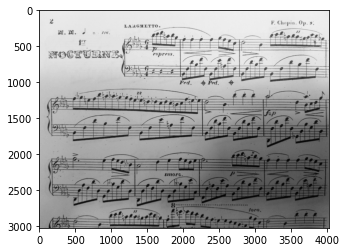

In [51]:
plt.imshow(pim1,cmap = plt.get_cmap('gray'))
plt.show()

In [52]:
pim2 = removeBkgdLighting(pim1, thumbnailFilterSize, thumbnailW, thumbnailH)

In [53]:
linesep, scores = estimateLineSep(pim2, estLineSep_NumCols, estLineSep_LowerRange, estLineSep_UpperRange, estLineSep_Delta)
targetH, targetW = calcResizedDimensions(pim2, linesep, targetLineSep)

In [54]:
linesep

18

In [55]:
targetH

1680

In [56]:
targetW

2240

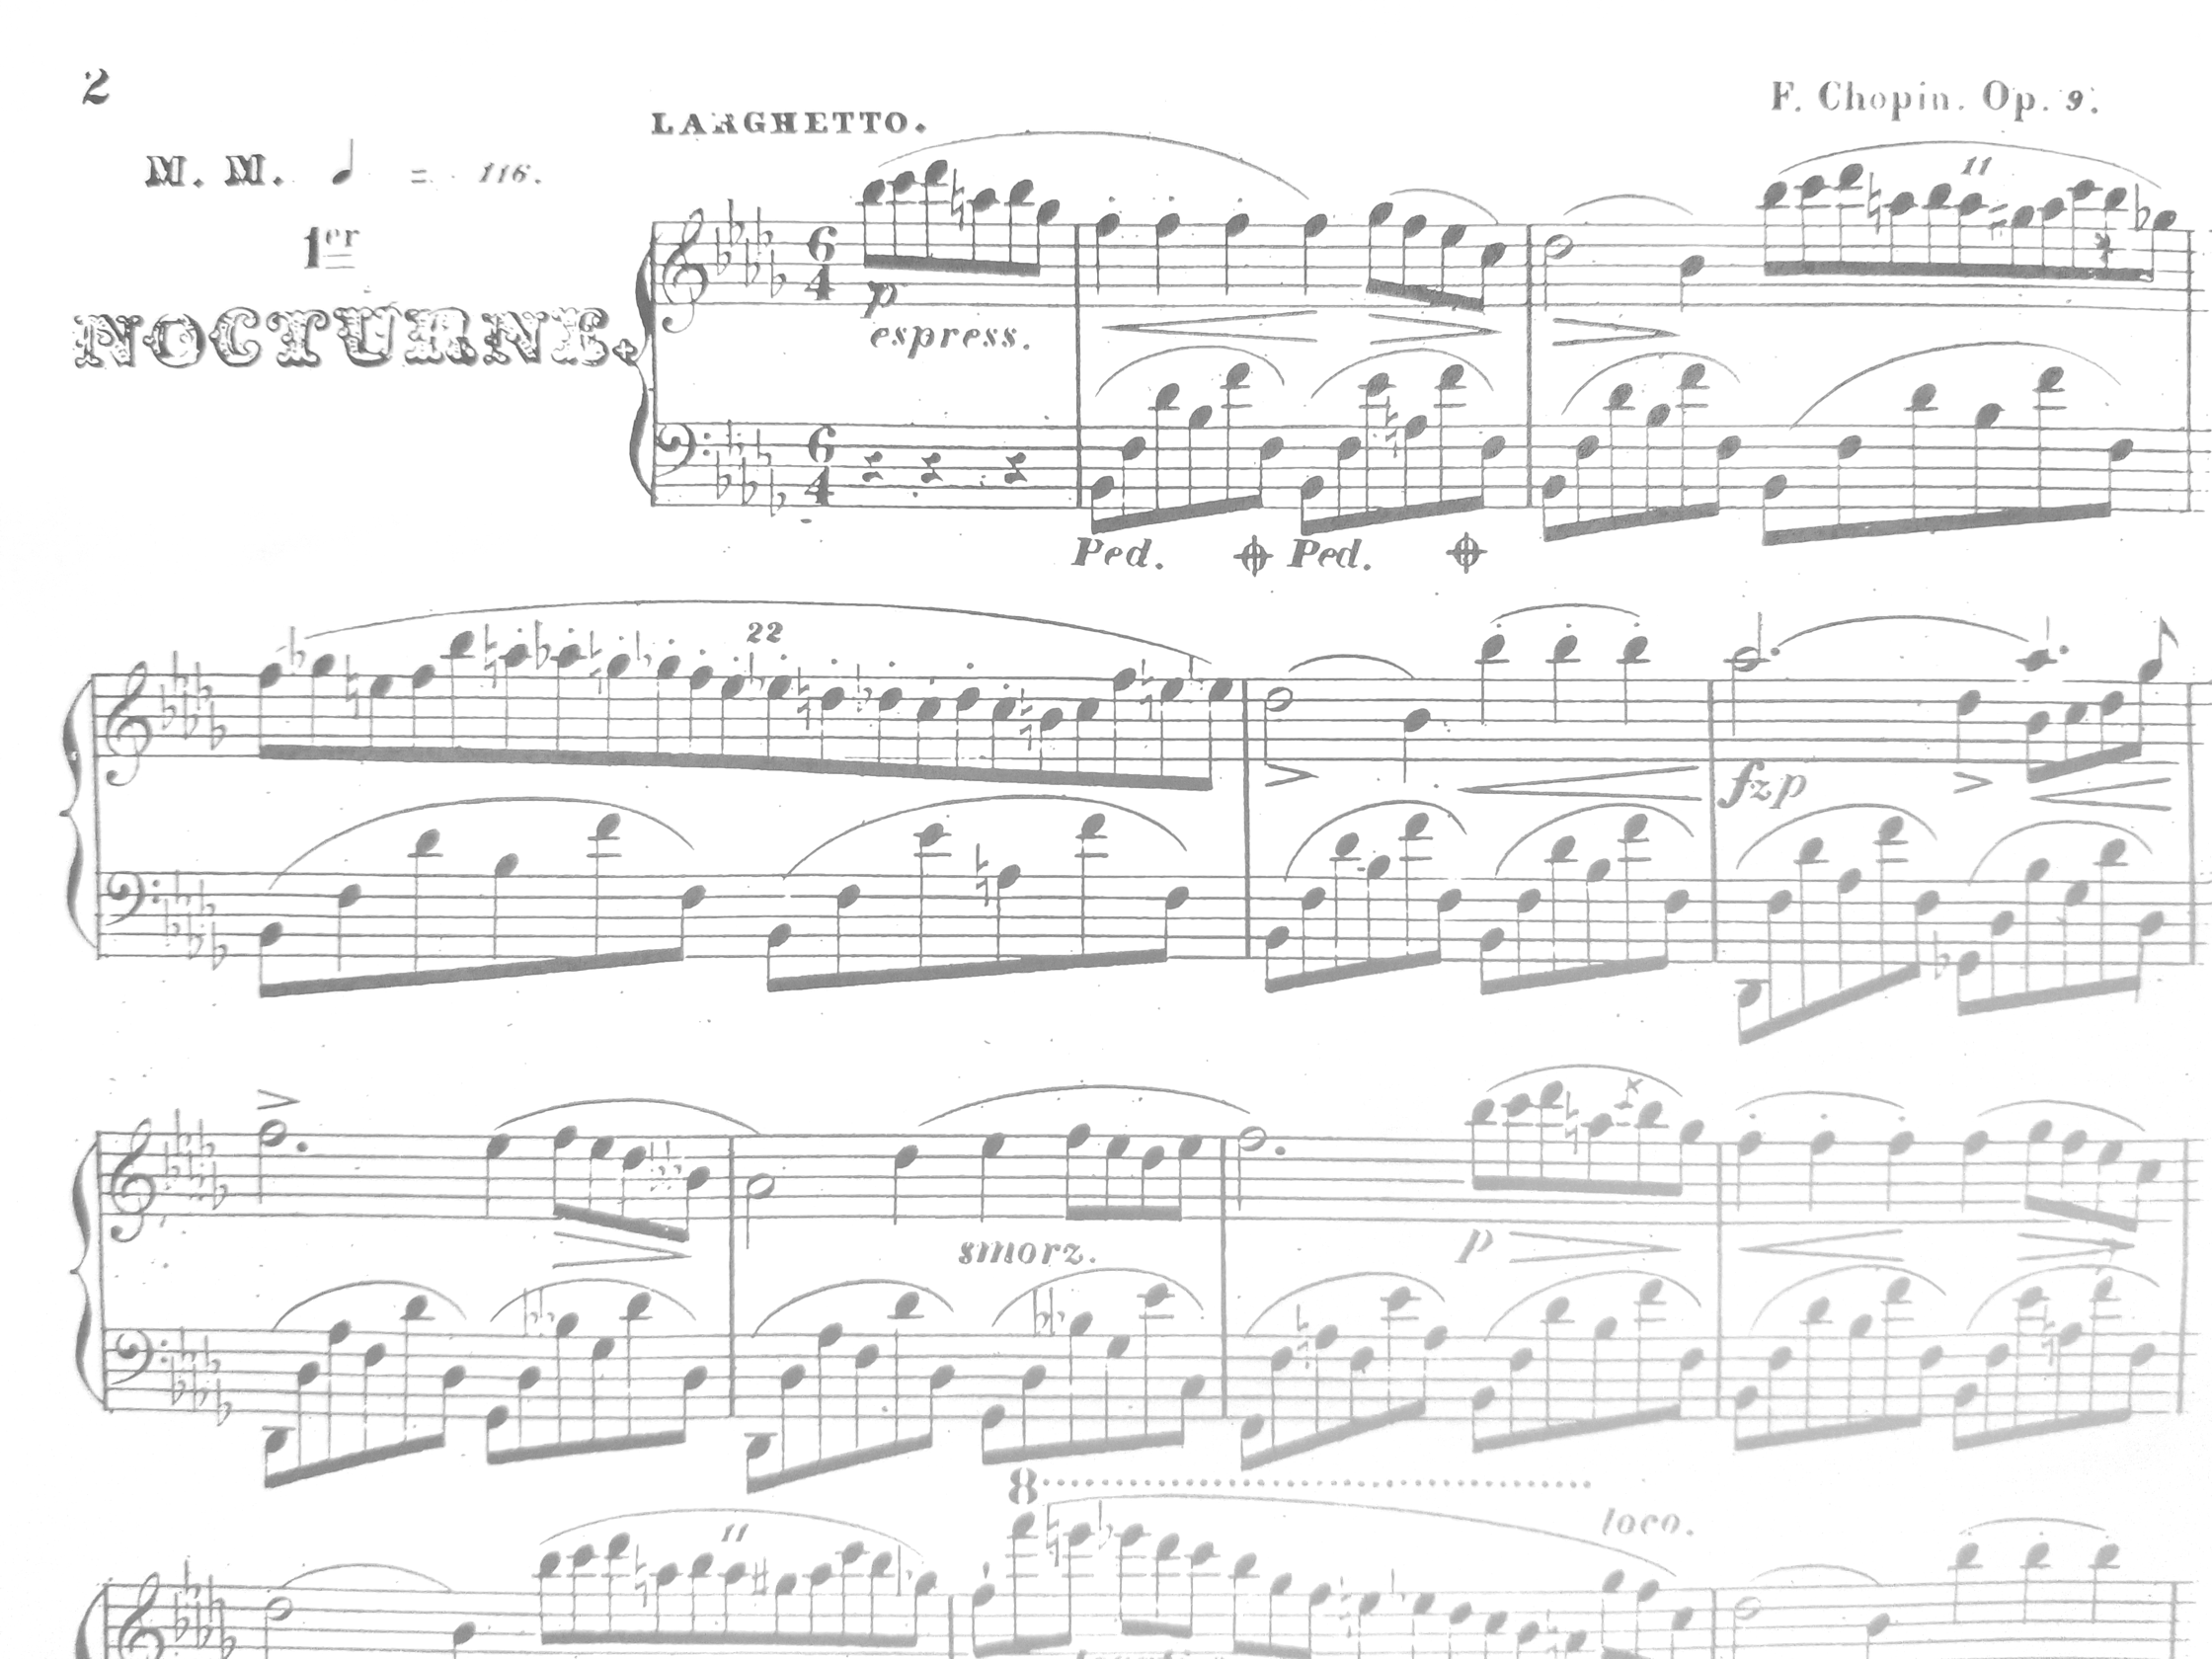

In [57]:
pim2 = pim2.resize((targetW,targetH))
pim2

In [58]:
X2 = getNormImage(pim2)

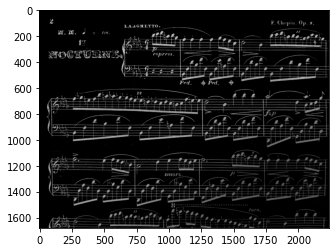

In [59]:
plt.imshow(X2,cmap ='gray')

In [60]:
hlines = isolateStaffLines(X2, morphFilterHorizLineSize, notebarFiltLen, notebarRemoval)

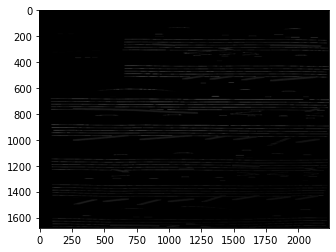

In [61]:
plt.imshow(hlines*255,cmap = "gray")

In [62]:
featmap, stavelens, columnWidth = computeStaveFeatureMap(hlines, calcStaveFeatureMap_NumCols, calcStaveFeatureMap_LowerRange, calcStaveFeatureMap_UpperRange, calcStaveFeatureMap_Delta)

/tmp/ipykernel_25810/1496562062.py:169: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  stavelens = np.zeros((len(lineseps)), dtype=(np.int))


In [63]:
featmap

array([[[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        ...,
        [2.12913725e+01, 1.37486275e+01, 4.84058824e+00, ...,
         6.44000000e+00, 6.32450980e+00, 1.08921569e+00],
        [4.97215686e+00, 1.70282353e+01, 6.76686275e+00, ...,
         1.15541176e+01, 1.46666667e+00, 9.33960784e+00],
        [1.35662745e+01, 1.56901961e+01, 1.01311765e+01, ...,
         1.12215686e+01, 2.57862745e+00, 2.21366667e+01]],

       [[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 

In [64]:
im3 = morphFilterCircle(pim2, morphFilterCircleSizeReduce, morphFilterCircleSizeExpand)

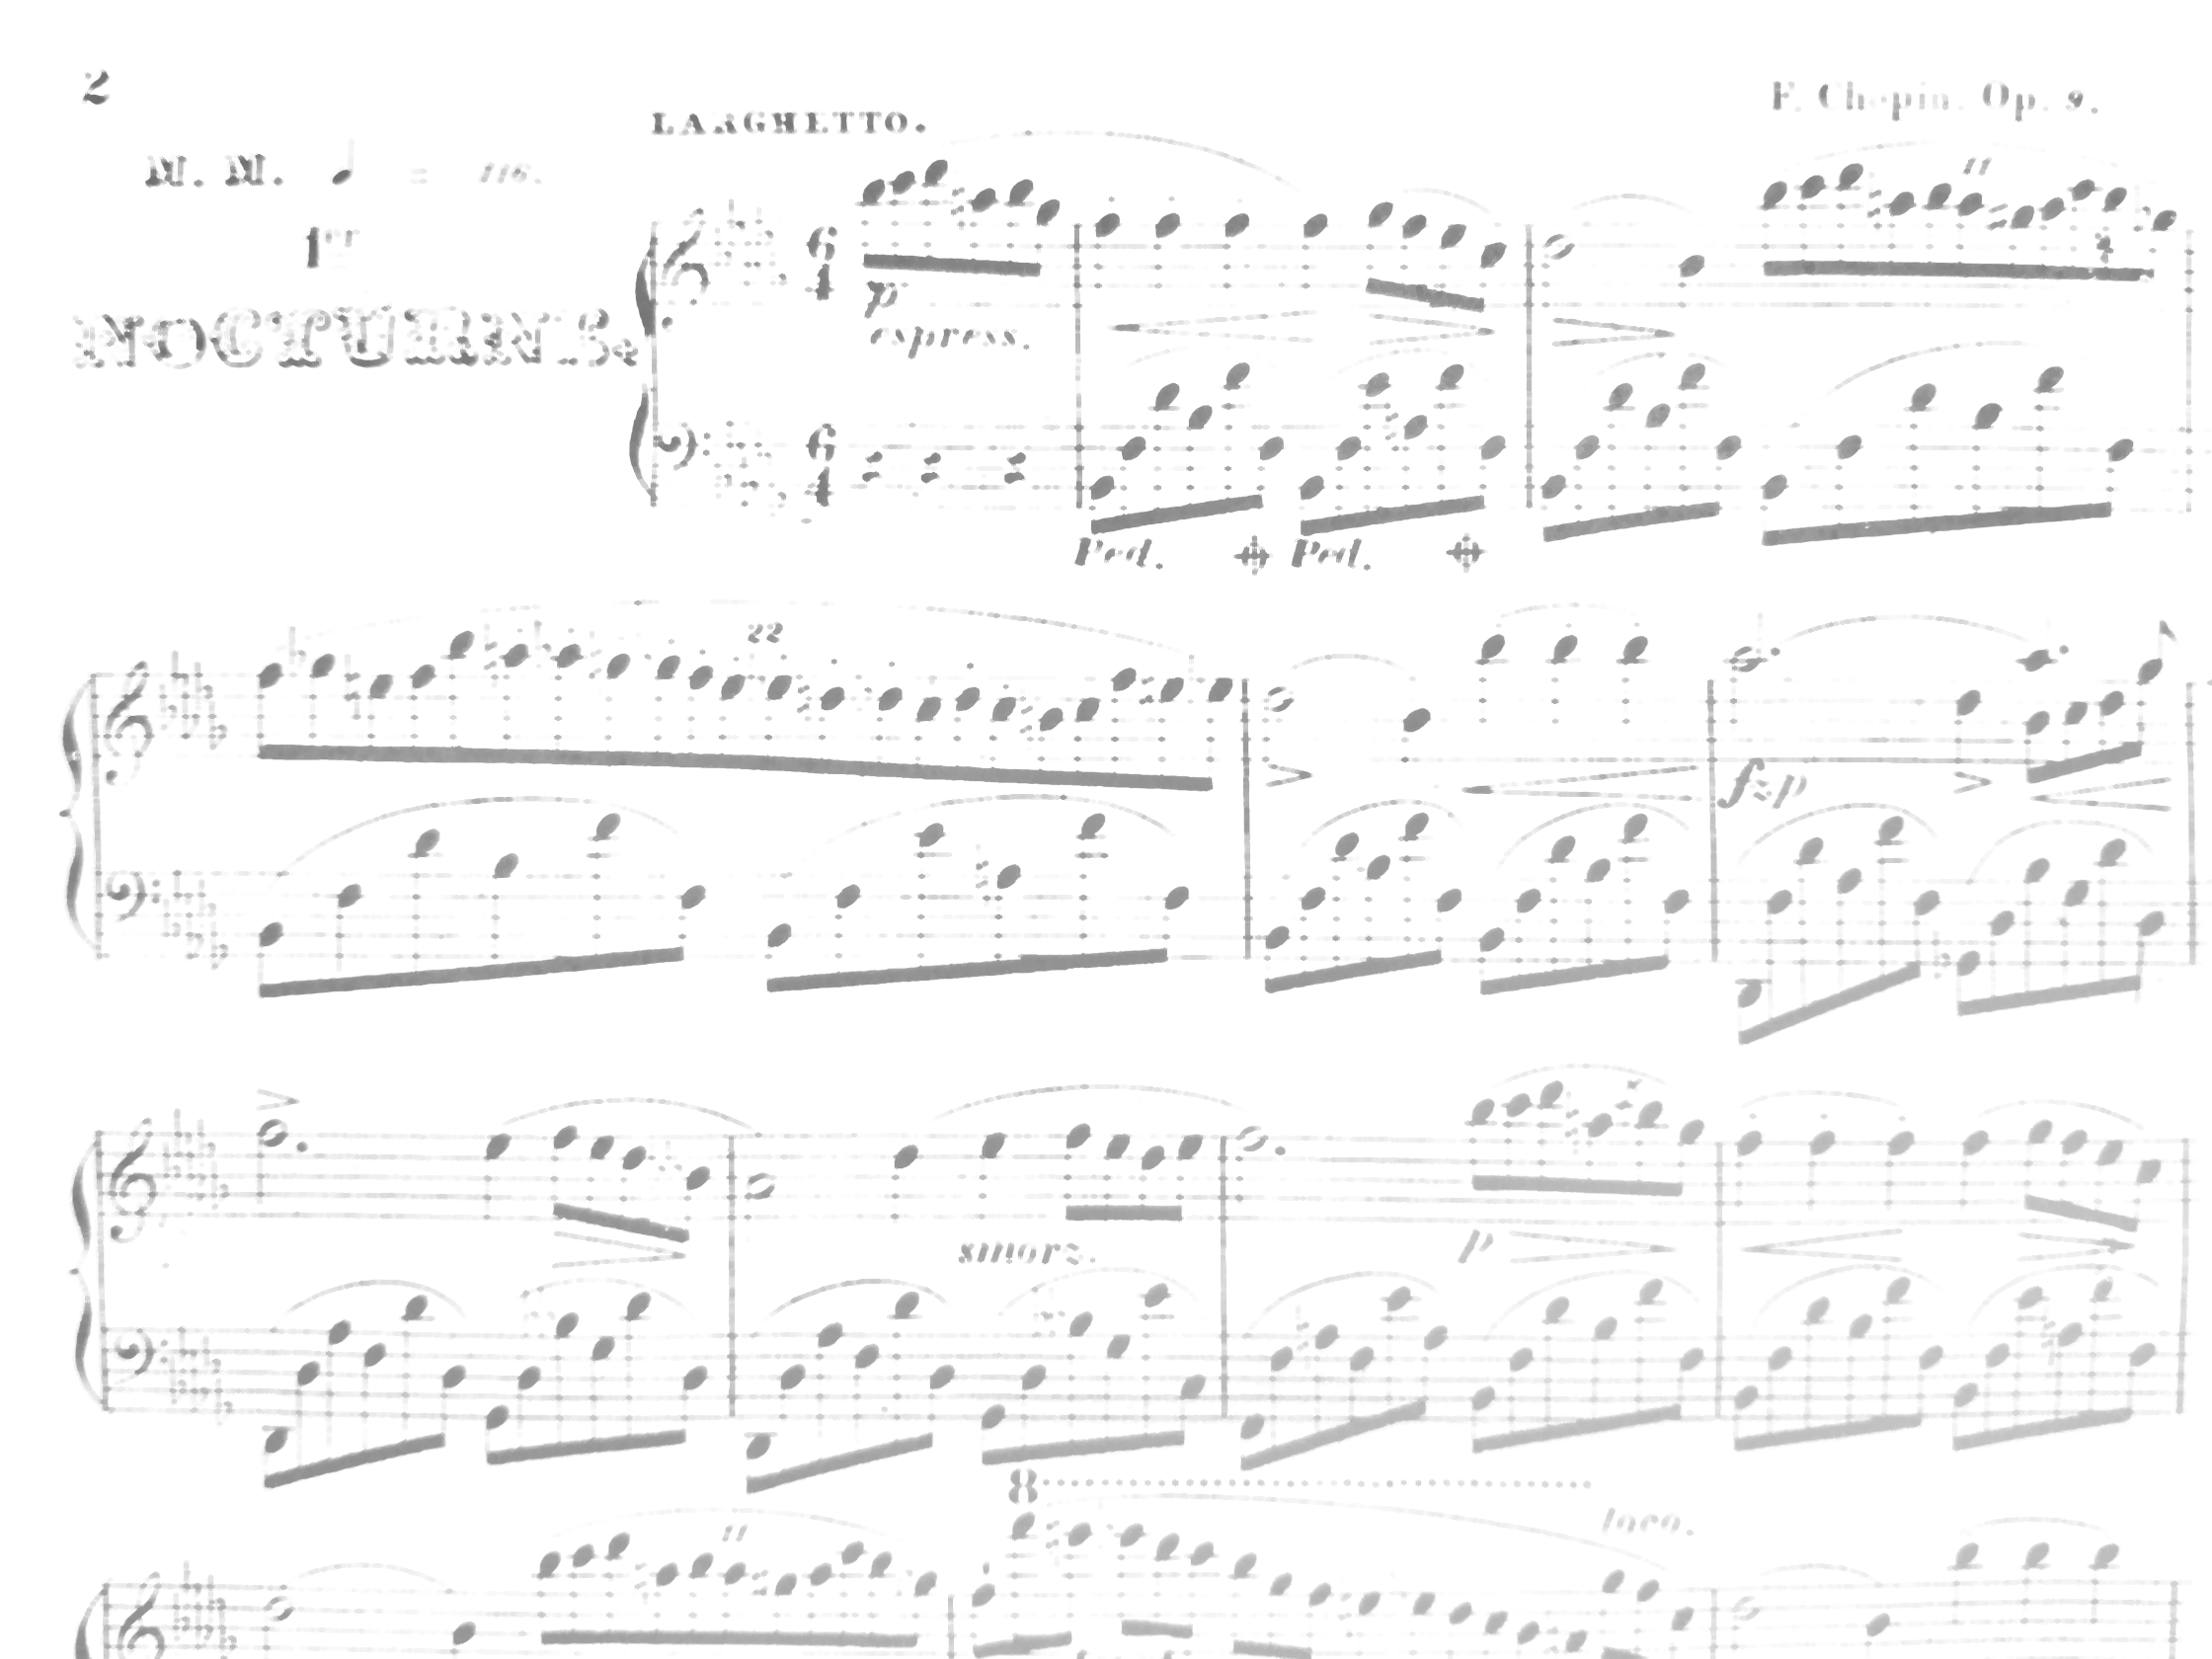

In [65]:
Image.fromarray(im3)

In [66]:
keypoints, im_with_keypoints = detectNoteheadBlobs(im3, notedetect_minarea, notedetect_maxarea)

In [67]:
X3 = getNormImage(im3)

In [68]:
ntemplate, numCrops = getNoteTemplate(X3, keypoints, noteTemplateSize)

In [69]:
chordBlockSpecs = (chordBlock_minH, chordBlock_maxH, chordBlock_minW, chordBlock_maxW, chordBlock_minArea, chordBlock_maxArea, chordBlock_minNotes, chordBlock_maxNotes)

In [70]:
len(ntemplate)

21

In [71]:
notes, img_binarized_notes = adaptiveNoteheadDetect(X3, ntemplate, notedetect_tol_ratio, chordBlockSpecs)

In [72]:
notes

[(80, 91, 92, 100),
 (72, 100, 84, 109),
 (99, 1794, 111, 1803),
 (81, 1795, 93, 1804),
 (90, 1798, 102, 1807),
 (85, 1842, 97, 1851),
 (96, 1842, 108, 1851),
 (92, 2093, 104, 2102),
 (95, 2100, 107, 2109),
 (96, 1916, 108, 1925),
 (109, 1915, 121, 1924),
 (96, 2040, 108, 2049),
 (109, 2039, 121, 2048),
 (123, 876, 135, 885),
 (111, 878, 123, 887),
 (126, 662, 138, 671),
 (111, 662, 123, 671),
 (119, 662, 131, 671),
 (124, 818, 136, 827),
 (113, 817, 125, 826),
 (125, 704, 137, 713),
 (113, 697, 125, 706),
 (119, 697, 131, 706),
 (124, 766, 134, 774),
 (125, 927, 135, 937),
 (161, 2005, 177, 2015),
 (170, 519, 180, 527),
 (175, 337, 187, 346),
 (170, 345, 182, 354),
 (179, 277, 188, 286),
 (242, 1084, 254, 1093),
 (227, 1086, 239, 1095),
 (229, 839, 240, 848),
 (239, 819, 251, 828),
 (230, 822, 242, 831),
 (248, 818, 260, 827),
 (233, 775, 242, 783),
 (246, 2130, 258, 2139),
 (240, 2125, 252, 2134),
 (255, 2126, 267, 2135),
 (260, 1086, 274, 1095),
 (277, 1087, 293, 1096),
 (304, 1086,

In [73]:
nhlocs, nhlen_est, nhwidth_est = getNoteheadInfo(notes)
estStaffLineLocs, sfiltlen = getEstStaffLineLocs(featmap, nhlocs, stavelens, columnWidth, maxDeltaRowInitial, int(-2 * targetLineSep))
staveMidpts = estimateStaffMidpoints(estStaffLineLocs, minNumStaves, maxNumStaves, minStaveSeparation)
staveIdxs, nhRowOffsets = assignNoteheadsToStaves(nhlocs, staveMidpts)
estStaffLineLocs, sfiltlen = getEstStaffLineLocs(featmap, nhlocs, stavelens, columnWidth, maxDeltaRowRefined, (nhRowOffsets - 2 * targetLineSep).astype(np.int))
nhvals = estimateNoteLabels(estStaffLineLocs)
vlines = isolateBarlines(X2, morphFilterVertLineLength, morphFilterVertLineWidth, maxBarlineWidth)
staveMapping, evidence = determineStaveGrouping(staveMidpts, vlines)
nhclusters, clusterPairs = clusterNoteheads(staveIdxs, staveMapping)

/tmp/ipykernel_25810/2469495724.py:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  estStaffLineLocs, sfiltlen = getEstStaffLineLocs(featmap, nhlocs, stavelens, columnWidth, maxDeltaRowRefined, (nhRowOffsets - 2 * targetLineSep).astype(np.int))


In [74]:
featmap

array([[[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        ...,
        [2.12913725e+01, 1.37486275e+01, 4.84058824e+00, ...,
         6.44000000e+00, 6.32450980e+00, 1.08921569e+00],
        [4.97215686e+00, 1.70282353e+01, 6.76686275e+00, ...,
         1.15541176e+01, 1.46666667e+00, 9.33960784e+00],
        [1.35662745e+01, 1.56901961e+01, 1.01311765e+01, ...,
         1.12215686e+01, 2.57862745e+00, 2.21366667e+01]],

       [[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 

In [75]:
combfilt,stavelen = getCombFilter(10)

In [76]:
len(combfilt)

41

In [77]:
nhdata = [(int(np.round(nhlocs[i][0])), int(np.round(nhlocs[i][1])), nhvals[i], nhclusters[i]) for i in range(len(nhlocs))]
bscore_query, events, eventIndices, staffLinesBoth = generateQueryBootlegScore(nhdata, clusterPairs, bootlegRepeatNotes, bootlegFiller, minColDiff=nhwidth_est)

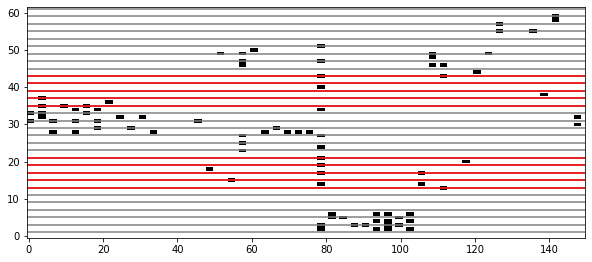

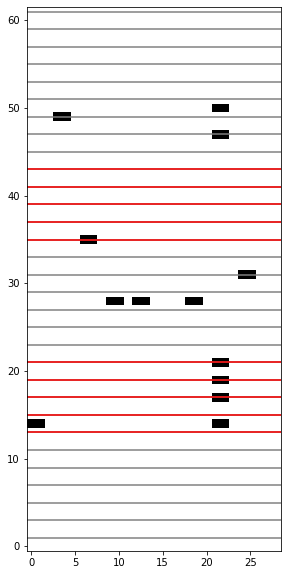

In [78]:
visualizeLongBootlegScore(bscore_query,[13, 15, 17, 19, 21, 35, 37, 39, 41, 43])

In [31]:
bscore_query

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [32]:
bscore_query.shape

(62, 533)

In [46]:
bscore_query.T[296]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [39]:
bscore_query[:,300]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [82]:
def decodeColumn(num):
    col = []
    for i in range(62):
        col.insert(0,num%2)
        num = int(num/2)
    return col

In [84]:
pkl_file = "bootleg_total/d%C4%8Cernohorsk%C3%BD,_Bohuslav_Mat%C4%9BjFugue_in_D_minor,_MAB_3.4_283513.pkl"
with open(pkl_file,"rb")as f:
    bs = pickle.load(f)

print(bs)
# total_bscore = np.array([]).reshape(62,0)
# for page in bs:
#     total_page = np.array([]).reshape(62,0)
#     for num in page:
#         col = np.array(decodeColumn(num)).reshape(62,-1)
#         total_page = np.concatenate((total_page,col),axis=1)
#     total_bscore = np.concatenate((total_bscore,total_page),axis=1)

# visualizeLongBootlegScore(total_bscore,[13, 15, 17, 19, 21, 35, 37, 39, 41, 43])

[[0, 2882303761517117440, 1441151880758558720, 288230376151711744, 1441151880758558720, 576460752303423488, 36028797018963968, 1073741824, 134217728, 458752, 262144, 0, 327680, 2882303761517117440, 288230376151711744, 0, 140737488355328, 281612482772992, 140737756790784, 140737488355328, 134217728, 282024732524544, 140737488355328, 20480, 3758096384, 134217728, 201326592, 201326592, 536870912, 0, 1152921504606846976, 576460752303423488, 0, 36028797018963968, 3458764513820540928, 262144, 0, 0], [], [2337066188800, 8796095119360, 67108864, 268435456, 8388608, 16777216, 5085845258240, 16777216, 67108864, 134217728, 2147483648, 8796109799424, 134217728, 67108864, 16777216, 4194304, 2097152, 1048576, 134217728, 33554432, 67108864, 1409353252864, 2147483648, 1073741824, 2097152, 4294967296, 16777216, 134217728, 67108864, 2508260900864, 1099511627776, 549755813888, 33554432, 134217728, 4194304, 8388608, 16777216, 134217728, 70368744177664, 268435456, 1073741824, 2199023255552], [67108864, 134